# Модуль 9. **Підбір гіперпараметрів НМ**

In [397]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import pandas as pd 

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
import copy

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [398]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [399]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [400]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}

labels = pd.DataFrame(labels_description)

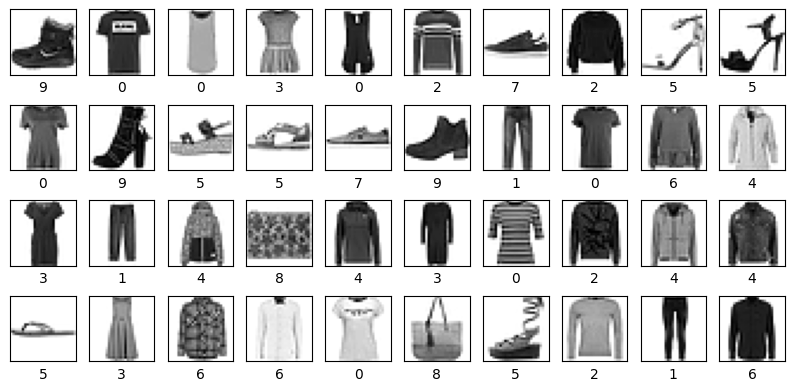

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [401]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

    Функція відображення графіків втрат і точності

In [402]:
def plt_history(history):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    for key, label in dict_data.items():
        plt.plot(
            epochs,
            history.history[key],
            color=color_loss if (key[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (key[:3] == "val") else linestyle_train,
            label=label,
        )

    plt.title("Точність та втрати на тренувальному та тестовому наборі")
    plt.xlabel("Епохі")
    plt.ylabel("Метрики")
    plt.legend()
    plt.show()

In [403]:
def plt_history___(history):

    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    data_plt = ["accuracy", "val_accuracy", "loss", "val_loss"]
    label_plt = [
        "Точність на тренувальному наборі",
        "Точність на тестовому наборі",
        "Втрати на тренувальному наборі",
        "Втрати на тестовому наборі",
    ]
    for i in range(len(data_plt)):
        plt.plot(
            epochs,
            history.history[data_plt[i]],
            color=color_loss if (data_plt[i][-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_plt[i][:3] == "val") else linestyle_train,
            label=label_plt[i],
        )

    plt.title("Точність та втрати на тренувальному та тестовому наборі")
    plt.xlabel("Епохі")
    plt.ylabel("Метрики")
    plt.legend()
    plt.show()

In [404]:
def plt_history_(history):

    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    data_plt = [
        {
            'data_': "accuracy",
            'label_': "Точність на тренувальному наборі",
            'color_': color_acc,
            'linestyle_': linestyle_train,
        },
        {
            'data_': "val_accuracy",
            'label_': "Точність на тестовому наборі",
            'color_': color_acc,
            'linestyle_': linestyle_test,
        },
        {
            'data_': "loss",
            'label_': "Втрати на тренувальному наборі",
            'color_': color_loss,
            'linestyle_': linestyle_train,
        },
        {
            'data_': "val_loss",
            'label_': "Втрати на тестовому наборі",
            'color_': color_loss,
            'linestyle_': linestyle_test,
        },
    ]

    for i in range(len(data_plt)):
        plt.plot(
            epochs,
            history.history[data_plt[i]["data_"]],
            label=data_plt[i]['label_'],
            color=data_plt[i]["color_"],
            linestyle=data_plt[i]['linestyle_'],
        )

    plt.title("Втрати та точність на тренувальному та тестовому наборі")
    plt.xlabel("Епохі")
    plt.ylabel("Метрики")
    plt.legend()
    plt.show()

In [405]:
def plt_history__(history):

    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    data_plt = ["accuracy", "val_accuracy", "loss", "val_loss"]
    color_plt = [color_acc, color_acc, color_loss, color_loss]
    linestyle_plt = [linestyle_train, linestyle_test, linestyle_train, linestyle_test]
    label_plt = [
        "Точність на тренувальному наборі",
        "Точність на тестовому наборі",
        "Втрати на тренувальному наборі",
        "Втрати на тестовому наборі",
    ]
    for i in range(len(data_plt)):
        plt.plot(
            epochs,
            history.history[data_plt[i]],
            color=color_plt[i],
            linestyle=linestyle_plt[i],
            label=label_plt[i],
        )

    plt.title("Точність та втрати на тренувальному та тестовому наборі")
    plt.xlabel("Епохі")
    plt.ylabel("Метрики")
    plt.legend()
    plt.show()

In [406]:
def plt_history_(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    color_acc = "royalblue"
    color_loss = 'peru'
    lw_test = 3
    lw_train = 2

    epochs = range(1, len(train_loss) + 1)

    plt.plot(
        epochs,
        train_acc,
        color=color_acc,
        # linewidth=lw_train,
        linestyle="--",
        label="Точність на тренувальному наборі",
    )
    plt.plot(
        epochs,
        val_acc,
        color=color_acc,
        # linewidth=lw_test,
        linestyle="-",
        label="Точність на тестовому наборі",
    )
    plt.plot(
        epochs,
        train_loss,
        color=color_loss,
        # linewidth=lw_train,
        linestyle="--",
        label="Втрати на тренувальному наборі",
    )
    plt.plot(
        epochs,
        val_loss,
        color=color_loss,
        # linewidth=lw_test,
        linestyle="-",
        label="Втрати на тестовому наборі",
    )

    plt.title("Втрати та точність на тренувальному та тестовому наборі")
    plt.xlabel("Епоха")
    plt.ylabel("Метрики")
    plt.legend()
    plt.show()

    Базова модель

c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8615 - loss: 0.3969
Точність на тестових даних: 0.8568000197410583
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 929us/step - accuracy: 0.8762 - loss: 0.3555
Точність на тренувальних даних: 0.8738999962806702


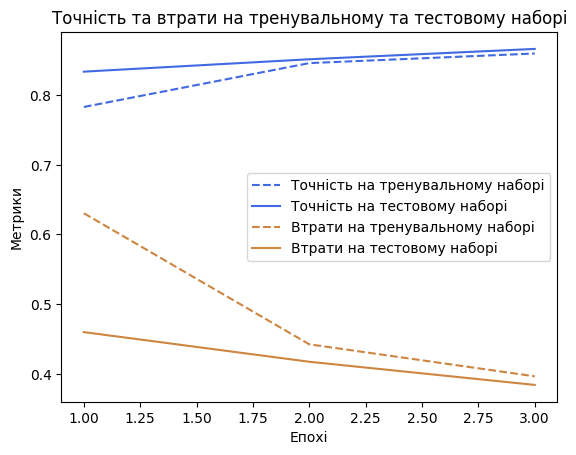

In [407]:
model = models.Sequential(
    [
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    train_images,
    train_labels,
    epochs=3,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Точність на тестових даних:", test_acc)

train_loss, train_acc = model.evaluate(train_images, train_labels)
print('Точність на тренувальних даних:', train_acc)

plt_history(history)

# model.save("my_model.keras")